In [1]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import matplotlib.pyplot as plt
import math
import warnings
import pyautogui
import matplotlib.pyplot as plt
from IPython.display import clear_output
from numpy.random import seed
seed(15)
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
which = pyautogui.confirm(text='Select Model:', buttons=['SVR - Poly', 'NN', 'SVR - Lin', 'Linear'])
load = pyautogui.confirm(text='Refresh or Existing Data:', buttons=['Refresh', 'Existing'])
tolog = pyautogui.confirm(text='Log Target Data?', buttons=['Yes', 'No'])
print(which, load, tolog)

NN Refresh Yes


In [110]:
dropcolumns = 5

inputs = pd.read_csv('traincleaned.csv')
testinputs = pd.read_csv('testcleaned.csv')
featureimportance = pd.read_csv('feature importance.csv')
print(featureimportance.shape)
featureimportance = featureimportance.rename(columns={'0': 'importance', '1':'feature'})
featureimportance = featureimportance.drop(columns=['Unnamed: 0'])
featureimportance = featureimportance.sort_values(by='importance')
featureimportance = featureimportance[0:dropcolumns]
featureimportance = featureimportance['feature'].tolist()

inputs = inputs.drop(columns=['SalePrice'])
alldata = pd.concat([inputs, testinputs])
alldata.set_index('Id', inplace=True)
alldata = alldata.fillna(0)
alldata = pd.get_dummies(alldata)
alldata = alldata.drop(columns=['Unnamed: 0'])
print(alldata.shape)
for column in featureimportance:
    try:
        alldata = alldata.drop(columns=column)
    except:
        print(f'Couldnt drop column {column}')

print(alldata.shape)

inputs = alldata.loc[0:1460,]
testinputs = alldata.loc[1461:]

numericalcolumns = []
for column in inputs.columns:
    if set(inputs[column].tolist()) != {0, 1}:
        numericalcolumns.append(column)

(345, 3)
(2917, 345)
(2917, 340)


In [111]:
import numpy
from sklearn.preprocessing import MinMaxScaler, StandardScaler

prices = pd.read_csv('traincleaned.csv')
prices = prices['SalePrice']
prices = np.array(prices)
if tolog == 'Yes':
    prices = np.log10(prices)
# Y_scaler = StandardScaler().fit(prices.reshape(-1,1))
# prices = Y_scaler.fit_transform(prices.reshape(-1,1))
prices

array([5.31910606, 5.25887663, 5.34927753, ..., 5.42569721, 5.15267048,
       5.16879202])

In [112]:
print(inputs.shape, prices.shape)

(1458, 340) (1458,)


In [113]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

if load == 'Refresh' and which != 'Linear':
    
#     bins = np.linspace(prices.min(), prices.max(), 4)
#     print(bins)
#     y_binned = np.digitize(prices, bins)

#     print(np.count_nonzero(y_binned == 1), np.count_nonzero(y_binned == 2), np.count_nonzero(y_binned == 3))
    X_train, X_test, y_train, y_test = train_test_split(inputs, prices, random_state=10, shuffle=True, test_size=.15)
    

    for column in numericalcolumns:
        try:
            if which == 'NN':
                X_scaler = MinMaxScaler().fit(X_train[column].values.reshape(-1,1))
            else:
                X_scaler = StandardScaler().fit(X_train[column].values.reshape(-1,1))
                
#             X_scaler = StandardScaler().fit(inputs[column].values.reshape(-1,1))
            
            X_train[column] = X_scaler.fit_transform(X_train[column].values.reshape(-1,1))
            X_test[column] = X_scaler.fit_transform(X_test[column].values.reshape(-1,1))
            testinputs[column] = X_scaler.fit_transform(testinputs[column].values.reshape(-1,1))
            inputs[column] = X_scaler.fit_transform(inputs[column].values.reshape(-1,1))
        except Exception as e:
            print(column, e)

#     y_scaler = MinMaxScaler().fit(y_train.reshape(-1,1))
#     y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
#     y_test = y_scaler.fit_transform(y_test.reshape(-1,1)) 
    
    X_train = X_train.values
    X_test = X_test.values
    testinputs = testinputs.values
    inputs = inputs.values
    
    objects = [X_train, X_test, testinputs, inputs, y_train, y_test]

    with open("objects.txt", "wb") as fp:
        pickle.dump(objects, fp)
        
else:
    if which != 'Linear':
        with open("objects.txt", "rb") as fp:
            objects = pickle.load(fp)

        X_train, X_test, testinputs, inputs, y_train, y_test = objects   
    
if which == 'Linear':
    testinputs = testinputs.values
    inputs = inputs.values


In [114]:
np.shape(inputs)
inputs

array([[0.18037319, 0.41487278, 0.41355932, ..., 1.        , 0.        ,
        1.        ],
       [0.32066344, 0.58599317, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.20248791, 0.44665767, 0.41937046, ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.2950933 , 0.55935568, 0.55786925, ..., 1.        , 0.        ,
        1.        ],
       [0.25708362, 0.51652353, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.31859019, 0.58389234, 0.        , ..., 1.        , 0.        ,
        1.        ]])

In [115]:
np.shape(prices)
prices

array([5.31910606, 5.25887663, 5.34927753, ..., 5.42569721, 5.15267048,
       5.16879202])

In [139]:
if which == 'NN':
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation
    import keras.backend as K
    import tensorflow as tf
    from keras import optimizers
    from keras import regularizers

    def compilemodel():
        model = Sequential()
        model.add(Dense(units=20,
                        activation='linear',
                       input_dim=inputs.shape[1],
                        kernel_regularizer=regularizers.l2(0.0001)))
        model.add(Dropout(0.5))
        model.add(Dense(units=20,
                         activation='linear',
                          kernel_regularizer=regularizers.l2(0.0001)))
#         model.add(Dense(units=20,
#                         activation='linear',
#                        input_dim=inputs.shape[1],
#                          kernel_regularizer=regularizers.l2(0.0001)))
        model.add(Dropout(0.5))
        model.add(Dense(units=1,
                       activation='linear',
                       kernel_regularizer=regularizers.l2(0.0001)))

        model.compile(loss='mse', optimizer='adam', metrics=['mse'])
        return model

    model = compilemodel()
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 20)                6820      
_________________________________________________________________
dropout_57 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_58 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 21        
Total params: 7,261
Trainable params: 7,261
Non-trainable params: 0
_________________________________________________________________


In [140]:
prices

array([5.31910606, 5.25887663, 5.34927753, ..., 5.42569721, 5.15267048,
       5.16879202])

In [141]:
# model = compilemodel()
# history = model.fit(
#     X_train,
#     y_train,
#     validation_data=(X_test, y_test),
#     epochs=500,
#     shuffle=True,
#     verbose=2,
# )

In [142]:
# %matplotlib
# metrics = list(history.history.keys())
# style = ['r-','ro','b-','bo']

# plt.figure() 
# for metric,style in  zip(metrics,style): 
    
#     plt.plot(history.history[metric],style,label=metric)
    
# plt.legend()
# plt.show()

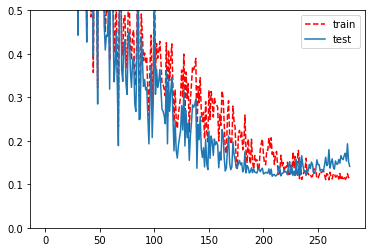

NameError: name 'error' is not defined

In [144]:
epochs = 300
totalepochs = 0
timethrough = 0
bestRMSLE = 1
bestepoch = 0



testRMSLElist = []
trainRMSLElist = []
difflist = []

if which == 'NN':
    model = compilemodel()

while which == 'NN':
    
    

    
    for x in range(epochs):

        model.fit(
            X_train,
            y_train,
            epochs=1,
            shuffle=True,
            verbose=0,
        )
        if x % 1 == 0 and x != 0:
            testpredictions = model.predict(X_test)
            trainpredictions = model.predict(X_train)

            testpredictions[testpredictions < y_train.min()/2] = y_train.min()
            trainpredictions[trainpredictions < y_train.min()/2] = y_train.min()
            
            if tolog == 'Yes':
                testpredictions = np.power(10, testpredictions)
                trainpredictions = np.power(10, trainpredictions)
                y_test = np.power(10, y_test)
                y_train = np.power(10, y_train)


            testRMSLE = math.sqrt(mean_squared_log_error(y_test, testpredictions))
            trainRMSLE = math.sqrt(mean_squared_log_error(y_train, trainpredictions))

            diff = round(abs(testRMSLE - trainRMSLE), 4)
            
            testRMSLElist.append(testRMSLE)
            trainRMSLElist.append(trainRMSLE)
            difflist.append(diff)
            
            if tolog == 'Yes':
                testpredictions = np.log10(testpredictions)
                trainpredictions = np.log10(trainpredictions)
                y_test = np.log10(y_test)
                y_train = np.log10(y_train)
                
            if testRMSLE < bestRMSLE and x > 190:
                bestRMSLE = testRMSLE
                bestepoch = x
                
            
                
        if x % 20 == 0 and x != 0:

            clear_output()
            xaxis = np.arange(0, len(testRMSLElist), 1)
            plt.plot(xaxis, trainRMSLElist, 'r--', label='train')
            plt.plot(xaxis, testRMSLElist, label='test')
#             plt.title(f'bestRMSLE = {round(bestRMSLE,4)}, bestEpoch {bestepoch}')
            plt.legend()
            
            
            plt.ylim(0, .5)
            plt.show()

            

#     print(f'{x + 1 + timethrough * epochs}, trainRMSLE = {round(trainRMSLE,4)}, testRMSLE={round(testRMSLE, 4)}, diff={diff}')        
#     print(f'bestRMSLE = {bestRMSLE}, bestEpoch {bestepoch}')

    totalepochs+=epochs
    timethrough+=1
    which = pyautogui.confirm(buttons=['NN', 'stop'])
    if which == 'stop':
        which = 'NN'
        error

In [134]:
#32, .1203
#34, .1171

In [135]:
# if which == 'NN':

#     folds = 1
#     epochs = 500

#     from sklearn.model_selection import KFold
#     kf = KFold(n_splits=folds, shuffle=True)
#     kf.get_n_splits(inputs, prices)

#     X_train = []
#     X_test = []
#     y_train = []
#     y_test = []

#     for i, (train_index, test_index) in enumerate(kf.split(inputs, prices)):
#         X_train.append(inputs[train_index])
#         X_test.append(inputs[test_index])
#         y_train.append(prices[train_index])
#         y_test.append(prices[test_index])





#     historylist = []

#     for fold in range(folds):
#         clear_output()
#         print(fold + 1)
        
#         model = compilemodel()
        
#         historylist.append(model.fit(
#             X_train[fold],
#             y_train[fold],
#             validation_data=(X_test[fold], y_test[fold]),
#             epochs=epochs,
#             shuffle=True,
#             verbose=0,
#         ))
    
#     clear_output()
#     print('Done')


In [136]:
# if which == 'NN':
#     addlist = {}
#     for key in historylist[0].history.keys():
#         addlist[key] = []
#         for fold in range(folds):
#             addlist[key].append(historylist[fold].history[key])

#     dftrainmse = pd.DataFrame()
#     dftestmse = pd.DataFrame()

#     for fold in range(folds):        
#         dftestmse[fold] = addlist['val_mean_squared_error'][fold]
#         dftrainmse[fold] = addlist['mean_squared_error'][fold]

#     dftestmse['avg'] = dftestmse.mean(axis=1)
#     dftrainmse['avg'] = dftrainmse.mean(axis=1)

#     avgtestmse = dftestmse['avg'].tolist()
#     avgtrainmse = dftrainmse['avg'].tolist()


#     plt.plot(avgtrainmse, 'r--', label = 'train')
#     plt.plot(avgtestmse, label = 'test')
#     plt.ylim(0, .3)
#     # plt.xlim(150, 300)
#     plt.legend()
#     plt.show()




In [145]:
if which == 'NN' or which == 'stop':
    which = 'NN'
    totalepochs = int(pyautogui.prompt(text='Enter epochs', default=bestepoch))
    print(f'Epochs = {totalepochs}')
    model = compilemodel()
    model.fit(
        inputs,
        prices,
        epochs=totalepochs,
        shuffle=True,
        verbose=0,
    )
    predictions = model.predict(testinputs)
    predictions[predictions < prices.min()/2] = prices.min()
    
    
    
    if tolog == 'Yes':
        predictions = np.power(10, predictions)
        



    print(predictions[0][0], len(predictions))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

(219, 1) (219,)


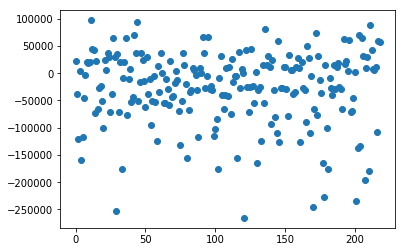

In [69]:
if which == 'NN':
    predicted = model.predict(X_test)
    # y_train = np.power(10, y_train)
    # predicted[predicted < y_train.min()/2] = y_train.min()
    if tolog == 'Yes':
        predicted_graph = np.power(10, predicted)
        y_test_graph = np.power(10, y_test)
    else:
        predicted_graph = predicted
        y_test_graph = y_test
        
    print(predicted_graph.shape, y_test_graph.shape)
    residuals = predicted_graph[0] - y_test_graph
    xaxis = np.arange(len(residuals))
    plt.scatter(xaxis, residuals)

(1239, 1) (1239,)


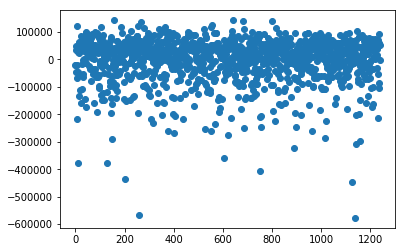

In [70]:
if which == 'NN':
    predicted = model.predict(X_train)
    if tolog == 'Yes':
        predicted_graph = np.power(10, predicted)
        y_train_graph = np.power(10, y_train)
    else:
        predicted_graph = predicted
        y_train_graph = y_train
        
    print(predicted_graph.shape, y_train_graph.shape)
    residuals = predicted_graph[0] - y_train_graph
    xaxis = np.arange(len(residuals))
    plt.scatter(xaxis, residuals)

In [71]:
if which == 'SVR - Poly':
    lastRMSLE = 1
    lastDiff = 1

    for C in range(200, 220, 1):
        print(f'C={C}')

        for degree in range(5, 7):

            for epsilon in [0.1, 1, 10, 20, 50, 75, 100]:

                
                for coef0 in range(2,3):
                    clf = SVR(kernel='poly', C=C, gamma='auto', degree=degree, epsilon=epsilon, coef0=coef0)
                    clf.fit(X_train, y_train) 
                    testpredictions = clf.predict(X_test)
                    trainpredictions = clf.predict(X_train)


                    testpredictions[testpredictions < y_train.min()/2] = y_train.min()
                    trainpredictions[trainpredictions < y_train.min()/2] = y_train.min()
                    
                    if tolog == 'Yes':
                        testpredictions = np.power(10, testpredictions)
                        trainpredictions = np.power(10, trainpredictions)
                        y_test = np.power(10, y_test)
                        y_train = np.power(10, y_train)
                    

                    testRMSLE = math.sqrt(mean_squared_log_error(y_test, testpredictions))
                    trainRMSLE = math.sqrt(mean_squared_log_error(y_train, trainpredictions))

                    if tolog == 'Yes':
                        testpredictions = np.log10(testpredictions)
                        trainpredictions = np.log10(trainpredictions)
                        y_test = np.log10(y_test)
                        y_train = np.log10(y_train)
                    
                    
                    diff = round(abs(testRMSLE - trainRMSLE), 3)
                    lastDiff = .03
                    if testRMSLE < lastRMSLE and diff < lastDiff:
                        lastDiff = diff
                        lastRMSLE = testRMSLE                    
                        print(f'C={C}, degree={degree}, epsilon={epsilon}, coef0={coef0}, trainRMSLE = {round(trainRMSLE,2)}, testRMSLE={round(testRMSLE, 5)}, diff={diff}, dropcolumns={dropcolumns}')
                        Cbest = C
                        degreebest = degree
                        epsilonbest = epsilon
                        coef0best = coef0
        
    print('---Done---')
    #C=130,degree=7,epsilon=0.1,coef0=3 0.1359030945302552 first submission
    #C=190,degree=9,epsilon=0.9,coef0=2 0.1359030945302552 second?
    #C=100,degree=7,epsilon=0.1,coef0=2 0.1359030945302552
    #C=200, degree=7, epsilon=4, coef0=2, standard scaler, no normalizing output data, 0.1248 Kaggle Score
    #C=131, degree=6, epsilon=0.1, coef0=2, trainRMSLE = 0.1, testRMSLE=0.11711, diff=0.018, dropcolumns=20, kaggle score 0.12321
    #C=210, degree=5, epsilon=13, coef0=3, trainRMSLE = 0.1, testRMSLE=0.13396, diff=0.034, no feat eng, no target scaling, dropcolumns = 4,
    #C=200, degree=6, epsilon=100, coef0=2, trainRMSLE = 0.09, testRMSLE=0.11705, diff=0.022, dropcolumns=4, kaggle = 0.12285

In [72]:
if which == 'SVR - Poly':
    predicted = clf.predict(X_test)
    
    if tolog == 'Yes':
        y_train = np.power(10, y_train)
        
    # predicted[predicted < y_train.min()/2] = y_train.min()
    predicted_graph = predicted
    y_test_graph = predicted
    print(predicted_graph.shape, y_test_graph.shape)
    residuals = predicted_graph[0] - y_test_graph
    xaxis = np.arange(len(residuals))
    plt.scatter(xaxis, residuals)

In [73]:
if which == 'SVR - Poly':
    predicted = clf.predict(X_train)
    if tolog == 'Yes':
        y_train = np.power(10, y_train)
    # predicted[predicted < y_train.min()/2] = y_train.min()
    predicted_graph = predicted
    y_train_graph = predicted
    print(predicted_graph.shape, y_train_graph.shape)
    residuals = predicted_graph[0] - y_train_graph
    xaxis = np.arange(len(residuals))
    plt.scatter(xaxis, residuals)

In [74]:
if which == 'SVR - Poly':
    try:
#         clf = SVR(kernel='poly', gamma='auto', C=240, degree=5, epsilon=0.1, coef0=2)#base
#         clf = SVR(kernel='poly', gamma='auto', C=100, degree=6, epsilon=0.1, coef0=2)
        #C=280, degree=6, epsilon=0.1, coef0=2, with newly cleaned data
        asdf
        clf = SVR(kernel='poly', gamma='auto', C=131, degree=6, epsilon=0.1, coef0=2)      
        print('Used entered hyperparameters')
        print(clf)
        
    except Exception as e:
        print(e)
        clf = SVR(kernel='poly', gamma='auto', C=Cbest, degree=degreebest, epsilon=epsilonbest, coef0=coef0best)
        print(f'C={Cbest}, degree={degreebest}, epsilon={epsilonbest}, coef0={coef0best}')
    
    clf.fit(inputs, prices) 
    predictions = clf.predict(testinputs)
    
    if tolog == 'Yes':
        predictions = np.power(10, predictions)
        
    predictions[predictions < y_train.min()/2] = y_train.min()
    # predictions = Y_scaler.inverse_transform(predictions)


    print(predictions)

In [75]:
if which == 'SVR - RBF':
    
    lastRMSLE = 1
    for C in [1e0, 1e1, 1e2, 1e3]:

        for gamma in np.logspace(-2, 2, 5):

            for epsilon in range(1,10):
                epsilon = epsilon/10

                clf = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
                clf.fit(X_train, y_train) 
                testpredictions = clf.predict(X_test)
                trainpredictions = clf.predict(X_train)
                
                testpredictions[testpredictions < y_train.min()/2] = y_train.min()
                trainpredictions[trainpredictions < y_train.min()/2] = y_train.min()
                
                if tolog == 'Yes':
                    testpredictions = np.power(10, testpredictions)
                    trainpredictions = np.power(10, trainpredictions)
                    y_test = np.power(10, y_test)
                    y_train = np.power(10, y_train)

                testRMSLE = math.sqrt(mean_squared_log_error(y_test, testpredictions))
                trainRMSLE = math.sqrt(mean_squared_log_error(y_train, trainpredictions))

                if tolog == 'Yes':
                    testpredictions = np.log10(testpredictions)
                    trainpredictions = np.log10(trainpredictions)
                    y_test = np.log10(y_test)
                    y_train = np.log10(y_train)

                diff = round(abs(testRMSLE - trainRMSLE), 3)
                lastDiff = .05
                if testRMSLE < lastRMSLE and diff < lastDiff:
                    lastDiff = diff
                    lastRMSLE = testRMSLE                    
                    print(f'C={C}, gamma={gamma}, epsilon={epsilon}, trainRMSLE = {round(trainRMSLE,2)}, testRMSLE={round(testRMSLE, 5)}, diff={diff}')
                    Cbest = C
                    gammabest = gamma
                    epsilonbest = epsilon

In [76]:
if which == 'SVR - RBF':
    clf = SVR(kernel='rbf', C=Cbest, gamma=gammabest, epsilon=epsilonbest)
    clf.fit(X_train, y_train) 
    predictions = clf.predict(testinputs)

In [146]:
if which == 'SVR - Lin':
    
    lastRMSLE = 1
    lastDiff = 1

    for C in range(1, 40, 1):

        clf = SVR(kernel='linear', C=C, gamma='auto')
        clf.fit(X_train, y_train) 
        testpredictions = clf.predict(X_test)
        trainpredictions = clf.predict(X_train)
        
        testpredictions[testpredictions < y_train.min()/2] = y_train.min()
        trainpredictions[trainpredictions < y_train.min()/2] = y_train.min()

        if tolog == 'Yes':
            testpredictions = np.power(10, testpredictions)
            trainpredictions = np.power(10, trainpredictions)
            y_test = np.power(10, y_test)
            y_train = np.power(10, y_train)


        try:
            testRMSLE = math.sqrt(mean_squared_log_error(y_test, testpredictions))
            trainRMSLE = math.sqrt(mean_squared_log_error(y_train, trainpredictions))
        except Exception as e:
            print(f'Error with {C}, {e}')
            continue

        if tolog == 'Yes':
            testpredictions = np.log10(testpredictions)
            trainpredictions = np.log10(trainpredictions)
            y_test = np.log10(y_test)
            y_train = np.log10(y_train)

        diff = round(abs(testRMSLE - trainRMSLE), 3)
        lastDiff = .05
        if testRMSLE < lastRMSLE and diff < lastDiff:
            lastDiff = diff
            lastRMSLE = testRMSLE                    
            print(f'C={C}, trainRMSLE = {round(trainRMSLE,2)}, testRMSLE={round(testRMSLE, 5)}, diff={diff}')
            Cbest = C

In [78]:
if which == 'SVR - Lin':
    try:
        sa
        clf = SVR(kernel='poly', gamma='auto', C=16)      
        print('Used entered hyperparameters')
        print(clf)
        print(e)
    except Exception as e:
        clf = SVR(kernel='poly', gamma='auto', C=Cbest)
        print(f'C={Cbest}')
    
    clf.fit(inputs, prices) 
    predictions = clf.predict(testinputs)
    
    if tolog == 'Yes':
        predictions = np.power(10, predictions)
        
    predictions[predictions < y_train.min()/2] = y_train.min()
    # predictions = Y_scaler.inverse_transform(predictions)


    print(predictions)

In [79]:
if which == 'Linear':
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()

    # Fitting our model with all of our features in X
    model.fit(inputs, prices)

    score = model.score(inputs, prices)

    predictions = model.predict(inputs)
    predictions = np.power(10, predictions)
    pricesunlogged = np.power(10, prices)

    RMSLE = math.sqrt(mean_squared_log_error(pricesunlogged, predictions))

    predictions = model.predict(testinputs)
    predictions = np.power(10, predictions)

    print(f'R2: {score}, RMSLE: {RMSLE}, dropcolumns: {dropcolumns}')
    #0.12363, R2 Score = .94, RMSLE = .0977, no scaling, drop columns = 150
    #.12054, R2: 0.9361934187245556, RMSLE: 0.10093248123296446, dropcolumns: 200
    #.12057, R2: 0.9299809808208424, RMSLE: 0.10573194685650467, dropcolumns: 225, with all feature engineering

In [80]:
if which == 'Linear':
    from sklearn.linear_model import Lasso

    for alpha in range(1):
        alpha = alpha/10
        lasso = Lasso(alpha=alpha).fit(inputs, prices)

        predictions = lasso.predict(inputs)
        predictions = np.power(10, predictions)
        pricesunlogged = np.power(10, prices)


        RMSLE = math.sqrt(mean_squared_log_error(pricesunlogged, predictions))

        r2 = lasso.score(inputs, prices)

        predictions = lasso.predict(testinputs)
        predictions = np.power(10, predictions)

        print(f"alpha: {alpha}, RMSLE: {RMSLE}, R2: {r2}, dropcolumns: {dropcolumns}")
    #.11974, alpha: 0.0, RMSLE: 0.1062362486329152, R2: 0.9293114626723123, dropcolumns: 225  

In [81]:
if which == 'Linear':
    from sklearn.linear_model import Ridge

    for alpha in range(2):
        alpha = alpha/10
        ridge = Ridge(alpha=alpha).fit(inputs, prices)

        predictions = ridge.predict(inputs)
        predictions = np.power(10, predictions)
        pricesunlogged = np.power(10, prices)


        RMSLE = math.sqrt(mean_squared_log_error(pricesunlogged, predictions))

        r2 = ridge.score(inputs, prices)

        predictions = ridge.predict(testinputs)
        predictions = np.power(10, predictions)

        print(f"alpha: {alpha}, RMSLE: {RMSLE}, R2: {r2}, dropcolumns: {dropcolumns}")

In [82]:
if which == 'Linear':
    from sklearn.linear_model import ElasticNet

    for alpha in range(1):
        alpha = alpha/10
        elasticnet = ElasticNet(alpha=alpha).fit(inputs, prices)

        predictions = elasticnet.predict(inputs)
        predictions = np.power(10, predictions)
        pricesunlogged = np.power(10, prices)


        RMSLE = math.sqrt(mean_squared_log_error(pricesunlogged, predictions))

        r2 = elasticnet.score(inputs, prices)

        predictions = elasticnet.predict(testinputs)
        predictions = np.power(10, predictions)

        print(f"alpha: {alpha}, RMSLE: {RMSLE}, R2: {r2}, dropcolumns: {dropcolumns}")

In [138]:
submittest = pd.read_csv('testcleaned.csv')
submittest = submittest[['Id']]
submittest['SalePrice'] = predictions
submittest.to_csv('BrandenSubmission.csv', index=False)
print(submittest.shape, len(predictions))
print(f'tolog = {tolog}')
submittest.head()

(1459, 2) 1459
tolog = Yes


,Id,SalePrice
0,1461,108488.382812
1,1462,137834.078125
2,1463,158202.734375
3,1464,166205.515625
4,1465,159165.000000
